In [1]:
from keras.models import Sequential, Model
from keras.layers import (Convolution2D, MaxPooling2D,
                          Dropout, GlobalAveragePooling2D,
                          BatchNormalization)
from keras.layers import Flatten, Dense, Input, concatenate
from keras.initializers import Constant, TruncatedNormal

Using TensorFlow backend.


In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [2]:
from keras import regularizers

In [3]:
# Left eye and right eye
# Is batch Normalization shared parameters btw left & right eye?
# Left & right eyes share CONV-1, CONV-2< 

DEFAULT_IMG_SIZE = (224, 224, 3)
# CONV-E1
eye_input = Input(shape=DEFAULT_IMG_SIZE)
conv_e1 = Convolution2D(
    filters=96, kernel_size=11, strides=4,
    bias_initializer=Constant(value=0),
    kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01),
    activation='relu', padding='valid',
    data_format='channels_last')(eye_input)
# need to incorporate weight_decay multiplication and learning rate multiplication 
maxpool_e1 = MaxPooling2D(pool_size=3, strides=2)(conv_e1)
# replace Local Reponse Normalization by Batch Normalization 
# Keras doesn't have LRN anymore
batchnorm_e1 = BatchNormalization(axis=-1)(maxpool_e1)
# Keras doesn't have group parameter
# CONV-E2
conv_e2 = Convolution2D(
    filters=256, kernel_size=5, padding='same',
    bias_initializer=Constant(value=1),
    kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01),
    activation='relu'
)(batchnorm_e1)
maxpool_e2 = MaxPooling2D(pool_size=3, strides=2)(conv_e2)
batchnorm_e2 = BatchNormalization(axis=-1)(maxpool_e2)
# CONV-E3
conv_e3 = Convolution2D(filters=384, padding='same', kernel_size=3,
                       bias_initializer=Constant(value=0),
                       kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01),
                       activation='relu')(batchnorm_e2)

init_eye_model = Model(eye_input, conv_e3)

left_eye_input = Input(shape=DEFAULT_IMG_SIZE)
right_eye_input = Input(shape=DEFAULT_IMG_SIZE)

out_left_eye = init_eye_model(left_eye_input)
out_right_eye = init_eye_model(right_eye_input)

# CONV-E4 -> weights are not shared
conv_e4_left = Convolution2D(filters=64, padding='valid', kernel_size=1,
                           bias_initializer=Constant(value=0),
                           kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01),
                           activation='relu')(out_left_eye)
conv_e4_right = Convolution2D(filters=64, padding='valid', kernel_size=1,
                           bias_initializer=Constant(value=0),
                           kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01),
                           activation='relu')(out_right_eye)
flat_conv_e4_left = Flatten()(conv_e4_left)
flat_conv_e4_right = Flatten()(conv_e4_right)
# concat these 2 layers
concat_eye_layer = concatenate([flat_conv_e4_left, flat_conv_e4_right])

# FC-E1
fc_e1 = Dense(units=128, activation='relu',
              bias_initializer=Constant(value=1),
              kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.001))(concat_eye_layer)
            

In [4]:
# Face Model
model = Sequential()
# CONV-F1
model.add(Convolution2D(filters=96, kernel_size=11, strides=4,
                       bias_initializer=Constant(value=0),
                       kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01),
                       activation='relu', padding='valid',
                       input_shape=DEFAULT_IMG_SIZE))
model.add(MaxPooling2D(pool_size=3, strides=2))
model.add(BatchNormalization(axis=-1))
# CONV-F2
model.add(Convolution2D(filters=256, kernel_size=5, padding='same',
                       bias_initializer=Constant(value=1),
                       kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01),
                       activation='relu'))
model.add(MaxPooling2D(pool_size=3, strides=2))
model.add(BatchNormalization(axis=-1))
# CONV-F3
model.add(Convolution2D(filters=384, kernel_size=3, padding='same',
                       bias_initializer=Constant(value=0),
                       kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01),
                       activation='relu'))
# CONV-F4 
model.add(Convolution2D(filters=64, kernel_size=1, padding='valid',
                       bias_initializer=Constant(value=0),
                       kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01),
                       activation='relu'))
# Question: Don't we need to flatten this first?
model.add(Flatten())
# FC-F1 
model.add(Dense(units=128, activation='relu',
               bias_initializer=Constant(value=1),
               kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.001)))
# FC-F2
model.add(Dense(units=64, activation='relu',
               bias_initializer=Constant(value=1),
               kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.001)))

face_input = Input(shape=DEFAULT_IMG_SIZE)
face_out = model(face_input)

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 96)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 26, 26, 96)        384       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 12, 12, 256)       1024      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 384)       885120    
__________

In [6]:
# Facegrid
FACEGRID_SIZE = (25, 25)
face_grid_input = Input(shape=FACEGRID_SIZE)
flatten_fg = Flatten()(face_grid_input)
fc_fg1 = Dense(units=256, activation='relu',
               bias_initializer=Constant(value=1),
               kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.001))(flatten_fg)
fc_fg2 = Dense(units=128, activation='relu',
               bias_initializer=Constant(value=1),
               kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.001))(fc_fg1)

In [7]:
# Concatenate all models
concat_all = concatenate([fc_e1, face_out, fc_fg2])
fc_1 = Dense(units=128, activation='relu',
             bias_initializer=Constant(value=1),
             kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.001))(concat_all)
fc_2 = Dense(units=2, bias_initializer=Constant(value=0),
             kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.001))(fc_1)

gaze_model = Model(inputs=[left_eye_input, right_eye_input,
                           face_input, face_grid_input],
                  outputs=fc_2)

gaze_model.compile(optimizer='rmsprop', loss='mean_squared_error')
#gaze_model.fit([data-here], epochs=100, batch_size=56)

In [8]:
gaze_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
model_1 (Model)                  (None, 12, 12, 384)   1536128     input_2[0][0]                    
                                                                   input_3[0][0]                    
____________________________________________________________________________________________________
conv2d_4 (Conv2D)                (None, 12, 12, 64)    24640       model_1[1][0]           

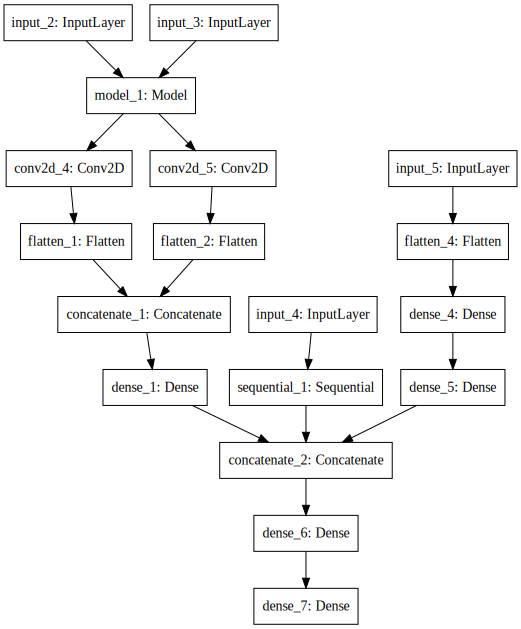

In [9]:
SVG(model_to_dot(gaze_model).create(prog='dot', format='svg'))

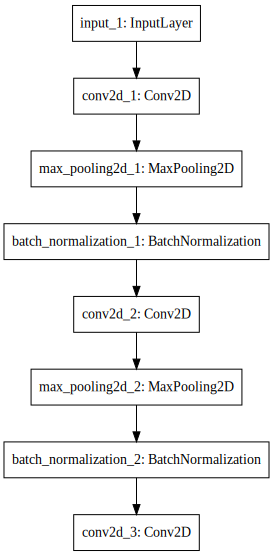

In [10]:
SVG(model_to_dot(init_eye_model).create(prog='dot', format='svg'))

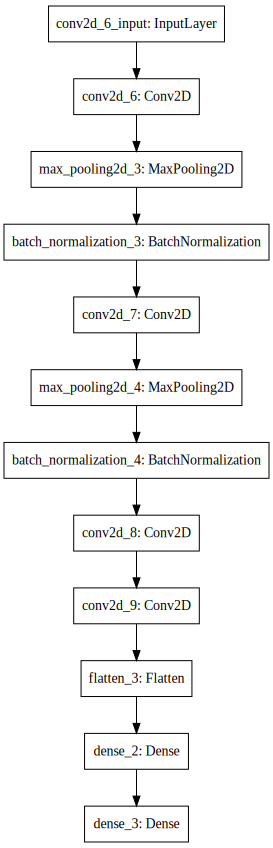

In [11]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))